### Problem 2: Contextual Representation Learning  

In [1]:
import torchtext
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

# Displaying a sample image in the dataset
import matplotlib.pyplot as plt
%matplotlib inline

import random, os
import numpy as np

device = torch.device('cuda:1')

# Sliding Window Size = 2 * Window_size_param + 1
WINDOW_SIZE_PARAM = 2 

# Number of Negative samples
NEG_SAMPLES = 4

/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed = 42):
    '''
        For Reproducibility: Sets the seed of the entire notebook.
    '''

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    # Sets a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(0)

In [3]:
# Reading the Tiny Shakespeare dataset file
text_corpus_raw = open("tiny-shakespeare.txt", "r").read()

Preprocessing: 

1) Removed the orator's name from the dataset
2) Splitted all compound words to its simple components

In [4]:
import re

def remove_orator(corpus):
    n = 0
    pre_corpus = []
    for line in corpus:
        
        # Searching for Orator names using re
        x = re.search("^([A-Za-z])+\s*([A-Za-z])*:$", line)
        if x:
            print("Removed line: ", line)
            n += 1
        else:
            pre_corpus.append(line)
    print("Total lines removed: ", n)
    return pre_corpus

In [5]:
# Breaks down compound words
text_corpus_raw = text_corpus_raw.replace("--", " ", -1)
text_corpus_raw = text_corpus_raw.split("\n")

# Removes orator's name
corpus = remove_orator(text_corpus_raw)


Removed line:  First Citizen:
Removed line:  All:
Removed line:  First Citizen:
Removed line:  All:
Removed line:  First Citizen:
Removed line:  All:
Removed line:  First Citizen:
Removed line:  All:
Removed line:  Second Citizen:
Removed line:  First Citizen:
Removed line:  Second Citizen:
Removed line:  All:
Removed line:  Second Citizen:
Removed line:  First Citizen:
Removed line:  Second Citizen:
Removed line:  First Citizen:
Removed line:  Second Citizen:
Removed line:  First Citizen:
Removed line:  All:
Removed line:  First Citizen:
Removed line:  Second Citizen:
Removed line:  First Citizen:
Removed line:  MENENIUS:
Removed line:  First Citizen:
Removed line:  MENENIUS:
Removed line:  First Citizen:
Removed line:  MENENIUS:
Removed line:  First Citizen:
Removed line:  MENENIUS:
Removed line:  First Citizen:
Removed line:  MENENIUS:
Removed line:  First Citizen:
Removed line:  MENENIUS:
Removed line:  First Citizen:
Removed line:  MENENIUS:
Removed line:  First Citizen:
Removed l

In [6]:
print("Length of Corupus: ", len(corpus))

Length of Corupus:  33440


In [7]:
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer("basic_english")

vocab = []
for line in corpus:

    # Tokenizes the input text into words
    tokens = tokenizer(line)

    # Adds the extracted words to a list
    vocab.extend(tokens)

In [8]:
# Stores all the unique words in the dataset and their frequencies
vocabulary = {}

# Calculates the frequency of each unique word in the vocabulary
for word in vocab:
    if word in vocabulary:
        vocabulary[word] += 1
    else:
        vocabulary[word] = 1

print("Number of unique words in the vocabulary: ", len(vocabulary))

Number of unique words in the vocabulary:  11978


In [9]:
# Stores the integer token for each unique word in the vocabulary
ids_vocab = {}

id = 0

# Assigns words in the vocabulary to integer tokens
for word, v in vocabulary.items():
    ids_vocab[word] = id
    id += 1

In [10]:
# Tokenization function
def tokenize(corpus, ids_vocab):
    """
        Converts words in the dataset to integer tokens
    """

    tokenized_corpus = []
    for line in corpus:
        new_line = []
        for word in line:
            if word in ids_vocab:
                new_line.append(ids_vocab[word])
        if len(new_line) > 1:
            tokenized_corpus.append(new_line)

    return tokenized_corpus

In [11]:
token_corpus = tokenize(vocab, ids_vocab)

In [12]:
"""
    Converts the tokenized corpus to skip-gram inputs of format:
    (target, contexts) where, 
    target = One hot encoding of target word
    contexts = Multi hot encoding of context words in the window
"""

window_size = WINDOW_SIZE_PARAM
    
vocab_size = len(ids_vocab)

skip_gram_input = []

for idx, line in enumerate(token_corpus):
    for word in range(len(line)):
        target = torch.zeros(vocab_size)
        context = torch.zeros(vocab_size)

        # One hot encoding of target word
        target[line[word]] = 1
        
        # Multi hot encoding of context words in the window
        i = 1
        while word-i >= 0 and i <= window_size:
            context[line[word-i]] = 1
            i += 1
            
        i = 1
        while word+i < len(line) and i <= window_size:
            context[line[word+i]] = 1
            i += 1
        
        skip_gram_input.append((target, context))

In [13]:
# Collates each skip-gram input samples into batches
def collate_fn(token_corpus):

    vocab_size = len(ids_vocab)
    batch_skip_input = torch.zeros(len(token_corpus), vocab_size).to(device)
    batch_skip_context = torch.zeros(len(token_corpus), vocab_size).to(device)

    for idx, xy in enumerate(token_corpus):

        x, y = xy
        batch_skip_input[idx, (x==1).nonzero()] = 1
        batch_skip_context[idx, (y==1).nonzero()] = 1
 
    return (batch_skip_input, batch_skip_context)

In [14]:
# Splits data into batches of defined size
from torch.utils.data import DataLoader

batch_size = 200

train_loader = DataLoader(skip_gram_input, batch_size, collate_fn=collate_fn)

#### Question 2.2

Network C_E (Encoder):

Architecture:

- Input Dimension: Vocabulary Size
- Output Dimension: Embedding Dimension
- 1 Linear Layer

Embedding Dimension = 300

In [15]:
class Encoder(nn.Module):

    def __init__(self, input_dim, emb_dim):
        super().__init__()

        self.lin = nn.Linear(input_dim, emb_dim)

    def forward(self, x):
        
        x = self.lin(x)
        return x

Network C_D (Decoder)

Architecture:

- Input Dimension: Embedding Dimension
- Output Dimension: Vocabulary Size
- 1 Linear Layer
- Softmax output function

In [16]:
class Decoder(nn.Module):

    def __init__(self, emb_dim, output_dim, neg_sampling):
        super().__init__()

        self.lin = nn.Linear(emb_dim, output_dim)
        self.neg_sampling = neg_sampling

    def forward(self, x, yb, neg_yb):
        
        x = self.lin(x)

        if self.neg_sampling:
            pos_x = yb * x
            neg_x = neg_yb * x
            x = torch.sigmoid(pos_x + neg_x)
        else:
            x = torch.softmax(x, dim=-1)
            
        return x

In [17]:
class Skip_Gram(nn.Module):

    def __init__(self, input_dim, emb_dim, neg_sampling = False):
        super().__init__()

        self.encoder = Encoder(input_dim, emb_dim).to(device)
        self.decoder = Decoder(emb_dim, input_dim, neg_sampling).to(device)

    def forward(self, x, yb=None, neg_yb = None):

        x = self.encoder(x)
        x = self.decoder(x, yb, neg_yb)

        return x
    
    def get_embeddings(self, x):

        return self.encoder(x)

#### Question 2.3

In [18]:
import torch 

vocab_size = len(ids_vocab)
model = Skip_Gram(vocab_size, 300)

opt = torch.optim.Adam(model.parameters(), lr=1e-4)

#loss_fn = F.cross_entropy

Loss function

minimize Loss = - log $\prod_{j=0, j\neq m}^{j=2m} softmax(h^T_{c-m+j}.v_t) $

where, 

m = Window size  
h = Hidden weights of Decoder  
v_t = Encoder output of target word

Inituition behind Loss function:

To maximize the probability of the context words and minimize the probability of non-context words for the given target word.

In [19]:
def loss_fn(pred, yb):

    yb = yb.to(torch.double)
    pred = pred.to(torch.double)

    loss_batch = - torch.mul(yb, torch.log(pred)).sum(dim = 1)

    loss = torch.mean(loss_batch)

    return loss

In [20]:
# Main training loop

total_epoch = 10

model.to(device)
model.train()

loss_train = []
for epoch in range(1, total_epoch+1):
    epoch_loss = 0
    print("Epoch: ", epoch)

    iterator = tqdm(train_loader)
    for xb, yb in iterator:
        pred = model.forward(xb)
        loss = loss_fn(pred, yb)

        loss.backward()

        opt.step()

        opt.zero_grad()
        epoch_loss += loss.item()
        iterator.set_postfix(loss = loss.item())

    print("Loss: ", epoch_loss / len(train_loader))  
    loss_train.append(epoch_loss)      

Epoch:  1


100%|██████████| 2627/2627 [02:46<00:00, 15.80it/s, loss=4.59]


Loss:  6.746796481647436
Epoch:  2


100%|██████████| 2627/2627 [02:36<00:00, 16.84it/s, loss=4.32]


Loss:  4.635385441684124
Epoch:  3


100%|██████████| 2627/2627 [02:38<00:00, 16.56it/s, loss=4.23]


Loss:  4.596267005520347
Epoch:  4


100%|██████████| 2627/2627 [02:44<00:00, 15.93it/s, loss=4.22]


Loss:  4.592661229515495
Epoch:  5


100%|██████████| 2627/2627 [02:35<00:00, 16.91it/s, loss=4.21]


Loss:  4.591845196476189
Epoch:  6


100%|██████████| 2627/2627 [02:40<00:00, 16.35it/s, loss=4.21]


Loss:  4.591569185035369
Epoch:  7


100%|██████████| 2627/2627 [02:40<00:00, 16.32it/s, loss=4.21]


Loss:  4.591457763026928
Epoch:  8


100%|██████████| 2627/2627 [02:34<00:00, 16.97it/s, loss=4.21]


Loss:  4.591404456782776
Epoch:  9


100%|██████████| 2627/2627 [02:35<00:00, 16.91it/s, loss=4.21]


Loss:  4.591374714526582
Epoch:  10


100%|██████████| 2627/2627 [02:38<00:00, 16.59it/s, loss=4.21]

Loss:  4.591355762066811


In [21]:
torch.save(model.state_dict(), 'skip_gram.pt')

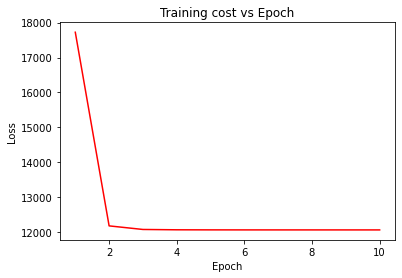

In [22]:
# Plots the training cost as the function of epoch

epoch_x = [x for x in range(1, total_epoch+1)]

plt.plot(epoch_x, loss_train, color = 'r')
plt.title("Training cost vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [23]:
# Gets the word embeddings of all words in the vocabulary from the Encoder

train_results = []

model.to('cpu')
words = []

shakes_vectors = {}
for x, v in ids_vocab.items():
    word = torch.zeros(vocab_size)
    word[v] = 1
    train_results.append(model.get_embeddings(word).detach().numpy())
    words.append(x)
    shakes_vectors[x] = model.get_embeddings(word)

#### Bonus [2] 

T-SNE Visualization of Word Embeddings

/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


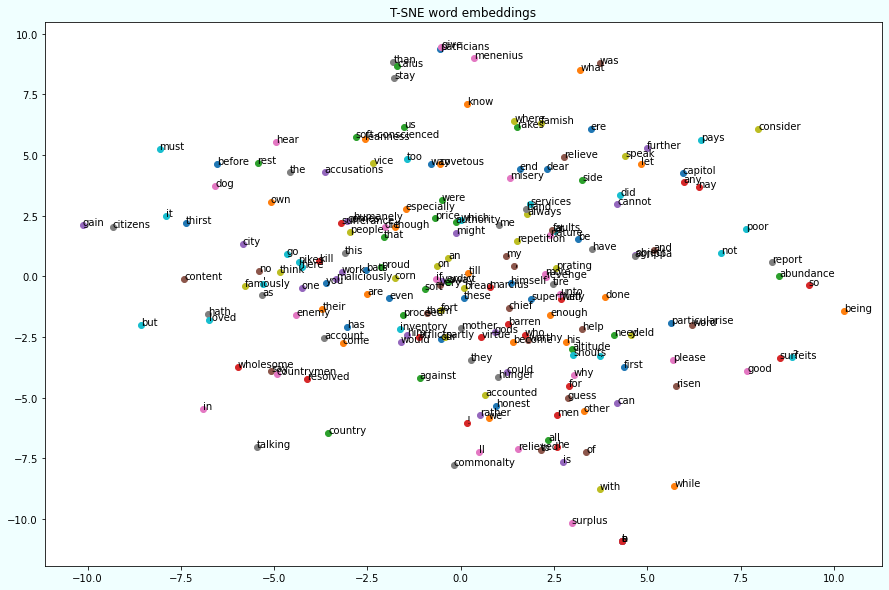

In [24]:
from sklearn.manifold import TSNE

# T-SNE visualization on word embeddings
tsne = TSNE(n_components=2, perplexity=40)
train_x = tsne.fit_transform(train_results)
plt.figure(figsize=(15, 10), facecolor="azure")

num_words_to_visualize = 0

# Threshold to limit the number of words to display in plot
threshold = 200
for x, v in ids_vocab.items():
    plt.scatter(train_x[v, 0], train_x[v, 1])
    plt.text(train_x[v, 0], train_x[v, 1], x)
    num_words_to_visualize += 1
    if num_words_to_visualize > threshold:
        break

plt.title("T-SNE word embeddings")
plt.show()

#### Bonus [1] 

Training Skip-Gram model using Negative Sampling

Negative Sampling:

sample ~ uniform(word_distribution^{3/4} / z)

where,   
z = Normalization constant

In [25]:
# Calculates the frequency of words in the corpus
freq_distr = {}
for key, value in vocabulary.items():
    freq_distr[key] = value ** (3/4)

z = sum(freq_distr.values())

for key, value in freq_distr.items():
    freq_distr[key] /= z

weights = torch.tensor(list(freq_distr.values())).to(device).unsqueeze(dim=0)
weights = weights.repeat(batch_size, 1)

Loss function

minimize Loss = - ( log $\sum_{(t,c) \in D} \sigma(h^T_c.v_c) $ + log $\sum_{(t,c) \in D'} \sigma(-h^T_c.v_c) $ )

where, 

m = Window size  
D = Positive samples  
D' = Negative sample  
h_c = Hidden weights of Decoder corresponding the the context  
v_t = Encoder output of target word

In [26]:
model_neg = Skip_Gram(vocab_size, 300, neg_sampling=True)

opt = torch.optim.Adam(model_neg.parameters(), lr=1e-4)

total_epoch = 10

def loss_fn(pred, yb, neg_yb):
    val = yb - neg_yb
    loss_batch =  -torch.mul(val, torch.log(pred)).sum(dim=1)
    loss = torch.mean(loss_batch)

    return loss

model_neg.to(device)
model_neg.train()

loss_train = []

for epoch in range(1, total_epoch+1):
    epoch_loss = 0

    print("Epoch: ", epoch)

    iterator = tqdm(train_loader)
    for xb, yb in iterator:
        
        neg_yb = torch.zeros(yb.shape, device=device) 
        neg_index = torch.multinomial(weights, NEG_SAMPLES)
        for i in range(yb.shape[0]):
            neg_yb[i, neg_index[i]] = -1

        pred = model_neg.forward(xb, yb, neg_yb)

        loss = loss_fn(pred, yb, neg_yb)

        loss.backward()

        opt.step()

        opt.zero_grad()
        epoch_loss += loss.item()
        iterator.set_postfix(loss = loss.item())

    print("Loss: ", epoch_loss / len(train_loader))  
    loss_train.append(epoch_loss)      

Epoch:  1


100%|██████████| 2627/2627 [03:08<00:00, 13.93it/s, loss=0.178]


Loss:  1.137235051281197
Epoch:  2


100%|██████████| 2627/2627 [02:59<00:00, 14.66it/s, loss=0.116]


Loss:  0.35997536608847913
Epoch:  3


100%|██████████| 2627/2627 [03:01<00:00, 14.47it/s, loss=0.576]


Loss:  0.3281406014420299
Epoch:  4


100%|██████████| 2627/2627 [03:07<00:00, 13.98it/s, loss=0.369]


Loss:  0.3216805237586116
Epoch:  5


100%|██████████| 2627/2627 [02:59<00:00, 14.63it/s, loss=0.285]


Loss:  0.31965778760121355
Epoch:  6


100%|██████████| 2627/2627 [03:07<00:00, 14.00it/s, loss=0.0972]


Loss:  0.3217008855317226
Epoch:  7


100%|██████████| 2627/2627 [03:06<00:00, 14.12it/s, loss=0.0957]


Loss:  0.31791047119157234
Epoch:  8


100%|██████████| 2627/2627 [03:03<00:00, 14.34it/s, loss=0.0978]


Loss:  0.32188085059634985
Epoch:  9


100%|██████████| 2627/2627 [02:59<00:00, 14.63it/s, loss=0.323]


Loss:  0.3193771575889889
Epoch:  10


100%|██████████| 2627/2627 [02:58<00:00, 14.70it/s, loss=0.0944]

Loss:  0.31993689259842495


In [27]:
torch.save(model.state_dict(), 'skip_gram_neg.pt')

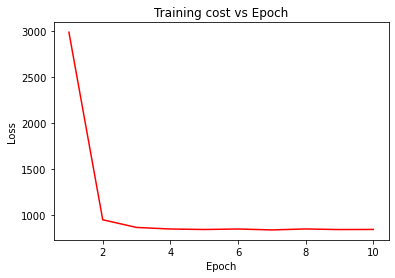

In [28]:
# Plots the training cost as the function of epoch

epoch_x = [x for x in range(1, total_epoch+1)]

plt.plot(epoch_x, loss_train, color = 'r')
plt.title("Training cost vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [29]:
# Gets the word embeddings of all words in the vocabulary from the Encoder

model_neg.to('cpu')

words_neg = []
shakes_neg_vectors = {}
train_results = []
for x, v in ids_vocab.items():
    word = torch.zeros(vocab_size)
    word[v] = 1
    train_results.append(model_neg.get_embeddings(word).detach().numpy())
    words_neg.append(x)
    shakes_neg_vectors[x] = model.get_embeddings(word)

/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


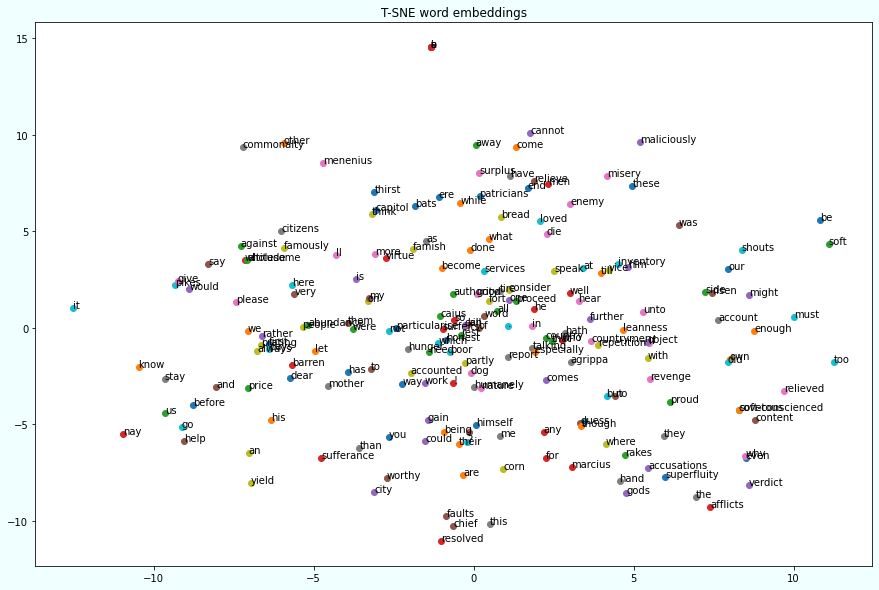

In [30]:
tsne = TSNE(n_components=2, perplexity=40)
train_x = tsne.fit_transform(train_results)
plt.figure(figsize=(15, 10), facecolor="azure")

num_words_to_visualize = 0
threshold = 200
for x, v in ids_vocab.items():
    plt.scatter(train_x[v, 0], train_x[v, 1])
    plt.text(train_x[v, 0], train_x[v, 1], x)
    
    num_words_to_visualize += 1
    if num_words_to_visualize > threshold:
        break

plt.title("T-SNE word embeddings")
plt.show()

#### Question 2.4

In [31]:
from torchtext.datasets import IMDB

# Downloads IMDB dataset
train_data = IMDB(root="data/", split='train')
test_data = IMDB(root="data/", split='test')

/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/torch/utils/data/datapipes/utils/common.py:24: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/torch/utils/data/datapipes/iter/selecting.py:54: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn("Lambda function is not supported for pickle, please use "


In [32]:
def split_indices(n, val_pct):

    # Determine size of Validation set
    n_val = int(val_pct * n)

    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

Preprocessing IMDB dataset

- Converted all letters to lower-case
- Removed special characters: '--', '`', '~', '<', '>', '*', '{', '}', '^', '=', '_', '[', ']', '|', '- '
- Removed less frequent words from vocabulary (words occurring less than 3 times)

In [44]:
tokenizer = get_tokenizer("basic_english")

vocabulary = []

# Splits the corpus into tokens of words
def get_vocabulary(data):
    num_samples = 0
    dataset = []
    for label, review in data:

        chars_to_remove = ['--', '`', '~', '<', '>', '*', '{', '}', '^', '=', '_', '[', ']', '|', '- ']
        
        for chars in chars_to_remove:
            review = review.replace(chars, " ", -1)
        
        num_samples += 1
        if label == "neg":
            label = 0
        else:
            label = 1

        tokens = tokenizer(review)
        vocabulary.extend(tokens)
        dataset.append((tokens, label))
    return dataset, num_samples

train_set, num_samples = get_vocabulary(train_data)
train_indices, val_indices = split_indices(num_samples, 0.1)

test_set, num_samples = get_vocabulary(test_data)

In [46]:
from torchtext.vocab import vocab
from collections import Counter, OrderedDict

# Creating the vocabulary from the tokens of words
counter = Counter(vocabulary)
counter_filtered = {}

for k, v in counter.items():
    if v > 3:
        counter_filtered[k] = v
        
sorted_by_freq_tuples = sorted(counter_filtered.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

# Adding <unk> token and default index
unk_token = '<unk>'

# Making default index same as index of unk_token
default_index = 0
v2 = vocab(ordered_dict, specials=[unk_token])
v2.set_default_index(default_index)

print("Number of words in Vocabulary: ", v2.__len__())

Number of words in Vocabulary:  46956


In [47]:
# Tokenization function
def tokenize(set):
    """
        Converts the tokens of words to tokens of integers
    """

    tokenized_set = []

    for review, label in set:
        tokens = torch.zeros(len(review), dtype=torch.int)

        for idx, word in enumerate(review):
            if word in v2:
                tokens[idx] = v2[word]
            
        tokenized_set.append((tokens, label))

    return tokenized_set

tokenized_train_set = tokenize(train_set)
tokenized_test_set = tokenize(test_set)

In [48]:
from torch.nn.utils.rnn import pad_sequence

# Collating the samples into batches by Post-padding
def collate_fn(batch):

    batch_review = [review for review, label in batch]
    batch_label  = [label for review, label in batch]

    labels = torch.zeros(len(batch_label), dtype=int)
    for idx, label in enumerate(batch_label):
        labels[idx] = label

    padded_batch_review = pad_sequence(batch_review, batch_first=True, padding_value=0)

    padded_batch = (padded_batch_review, labels)

    return padded_batch

In [49]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# Splitting the dataset into batches
batch_size = 100

train_sampler   = SubsetRandomSampler(train_indices)
train_loader    = DataLoader(tokenized_train_set, batch_size, sampler=train_sampler, collate_fn=collate_fn)

val_sampler     = SubsetRandomSampler(val_indices)
val_loader      = DataLoader(tokenized_train_set, batch_size, sampler=val_sampler, collate_fn=collate_fn)

test_loader     = DataLoader(tokenized_test_set, batch_size, collate_fn=collate_fn)

#### Network D

Architecture:

- First layer: Bi-LSTM with hidden dimension 200
- Followed by 2 fully connected Linear layers  
  - Linear layer 1 - Input dimension 400, Output Dimension 100
  - Linear layer 2 - Input dimension 100, Output Dimension 1
- Output function: Sigmoid
- Dropout of 25%

Loss Function: Binary Cross-Entropy Loss

In [62]:
class SentimentClassifier(nn.Module):

    def __init__(self, input_dim, emb_dim, hidden_dim, vocab_len, embeds):
        
        super().__init__()

        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding.from_pretrained(embeds, freeze=True, padding_idx=0)

        self.lstm = nn.LSTM(input_size = emb_dim, hidden_size = 200, num_layers =1, batch_first = True, bidirectional = True)

        self.dropout = nn.Dropout(0.25)
        self.lin1 = nn.Linear(400, 100)
        self.lin2 = nn.Linear(100, 1)

    def forward(self, xb):

        x = self.embeddings(xb)
        x, y = self.lstm(x)
        x = torch.cat((y[0][0, :, :], y[0][1, :, :]), dim = 1)
        x = x.squeeze(dim=0)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.lin2(x)
        x = torch.sigmoid(x)
        return x.squeeze(dim=1)

#### Question 2.5

IMDB movie review classification task using Embeddings from Skip-gram model trained on Tiny-Shakespeare dataset.

Hyperparameters:

- Embedding dimension: 300
- Learning rate: 1e-3
- Stopping Criteria: Early Stopping
- Maximum epochs: 25

Test Accuracy: 68.61 %

In [63]:
VOCAB = "shakes"

emb_dim = 300

embeds = torch.zeros(v2.__len__(), emb_dim)
n = 0
m = 0
for index in range(v2.__len__()):
    token = v2.lookup_token(index)

    if token in shakes_vectors:
        embeds[index] = shakes_vectors[token]
        n+=1
    else:
        embeds[index] = torch.rand(emb_dim)
        m += 1
print("Number of words present in tiny shakespeare: ",n)
print("Number of words randomly initialized: ", m)

Number of words present in tiny shakespeare:  7962
Number of words randomly initialized:  38994


In [75]:
model = SentimentClassifier(100, emb_dim, 600, v2.__len__(), embeds)
model.to(device)
model.train()

lr = 1e-3
opt = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = F.binary_cross_entropy

In [76]:
# Main training loop

num_epochs = 25

sets = [train_loader, val_loader]
desc = ["Training", "Validation"]

train_loss, val_loss = [], []
for epoch in range(1, num_epochs+1):
    print("Epoch: ", epoch)

    for s in range(2):
        epoch_loss = 0
        acc = 0
        n = 0

        if s == 0:
            model.train()
        else:
            model.eval()

        iterator = tqdm(sets[s])
        for xb, yb in iterator:
            xb = xb.to(device)
            yb = yb.to(device).to(float)
            y = model.forward(xb).to(float)
            
            loss = loss_fn(y, yb)

            if s == 0:
                loss.backward()
                opt.step()
                opt.zero_grad()

            epoch_loss += loss.item()

            cur_acc = 0
            for i in range(xb.shape[0]):
                if round(y[i].item()) == yb[i]:
                    cur_acc += 1
            acc += cur_acc
            n += xb.shape[0]

            iterator.set_postfix(loss = loss.item(), accuracy = cur_acc/xb.shape[0], set=desc[s]+" set")
        print(desc[s]+" Loss: ", epoch_loss/len(sets[s]))
        print(desc[s]+" Accuracy: ", acc/n)
        if s == 0:
            train_loss.append(epoch_loss/len(sets[s]))
        else:
            val_loss.append(epoch_loss/len(sets[s]))

    if epoch > 15 and val_loss[-1] - val_loss[-2] > 0.1/len(sets[s]):
        print("--- Stopping Training ---")
        break

Epoch:  1


100%|██████████| 225/225 [00:27<00:00,  8.05it/s, accuracy=0.66, loss=0.682, set=Training set]


Training Loss:  0.6934663377546373
Training Accuracy:  0.5052444444444445


100%|██████████| 25/25 [00:01<00:00, 19.80it/s, accuracy=0.5, loss=0.694, set=Validation set] 


Validation Loss:  0.6948910375218794
Validation Accuracy:  0.482
Epoch:  2


100%|██████████| 225/225 [00:28<00:00,  7.90it/s, accuracy=0.56, loss=0.687, set=Training set]


Training Loss:  0.6927450686749983
Training Accuracy:  0.5122222222222222


100%|██████████| 25/25 [00:01<00:00, 19.76it/s, accuracy=0.51, loss=0.693, set=Validation set]


Validation Loss:  0.6935780122913746
Validation Accuracy:  0.5
Epoch:  3


100%|██████████| 225/225 [00:28<00:00,  7.86it/s, accuracy=0.52, loss=0.69, set=Training set] 


Training Loss:  0.6903537271115817
Training Accuracy:  0.5307111111111111


100%|██████████| 25/25 [00:01<00:00, 19.88it/s, accuracy=0.54, loss=0.69, set=Validation set] 


Validation Loss:  0.6905795742546259
Validation Accuracy:  0.5316
Epoch:  4


100%|██████████| 225/225 [00:28<00:00,  7.84it/s, accuracy=0.5, loss=0.692, set=Training set] 


Training Loss:  0.687314264414502
Training Accuracy:  0.5444444444444444


100%|██████████| 25/25 [00:01<00:00, 19.94it/s, accuracy=0.59, loss=0.675, set=Validation set]


Validation Loss:  0.6853225095722241
Validation Accuracy:  0.5528
Epoch:  5


100%|██████████| 225/225 [00:28<00:00,  7.88it/s, accuracy=0.63, loss=0.67, set=Training set] 


Training Loss:  0.6821005880108967
Training Accuracy:  0.5653777777777778


100%|██████████| 25/25 [00:01<00:00, 20.09it/s, accuracy=0.6, loss=0.664, set=Validation set] 


Validation Loss:  0.68556411126692
Validation Accuracy:  0.5476
Epoch:  6


100%|██████████| 225/225 [00:28<00:00,  7.90it/s, accuracy=0.53, loss=0.693, set=Training set]


Training Loss:  0.6729339825021643
Training Accuracy:  0.5827111111111111


100%|██████████| 25/25 [00:01<00:00, 20.39it/s, accuracy=0.5, loss=0.703, set=Validation set] 


Validation Loss:  0.6778713439570574
Validation Accuracy:  0.566
Epoch:  7


100%|██████████| 225/225 [00:28<00:00,  7.90it/s, accuracy=0.59, loss=0.664, set=Training set]


Training Loss:  0.6726914881468555
Training Accuracy:  0.5813777777777778


100%|██████████| 25/25 [00:01<00:00, 20.14it/s, accuracy=0.45, loss=0.739, set=Validation set]


Validation Loss:  0.6834641116661027
Validation Accuracy:  0.554
Epoch:  8


100%|██████████| 225/225 [00:28<00:00,  7.85it/s, accuracy=0.51, loss=0.734, set=Training set]


Training Loss:  0.6601861563274518
Training Accuracy:  0.6008888888888889


100%|██████████| 25/25 [00:01<00:00, 20.13it/s, accuracy=0.52, loss=0.695, set=Validation set]


Validation Loss:  0.6669044900427338
Validation Accuracy:  0.592
Epoch:  9


100%|██████████| 225/225 [00:28<00:00,  8.00it/s, accuracy=0.58, loss=0.716, set=Training set]


Training Loss:  0.6460988519184543
Training Accuracy:  0.6278666666666667


100%|██████████| 25/25 [00:01<00:00, 20.17it/s, accuracy=0.61, loss=0.678, set=Validation set]


Validation Loss:  0.645338193673835
Validation Accuracy:  0.6328
Epoch:  10


100%|██████████| 225/225 [00:28<00:00,  7.93it/s, accuracy=0.78, loss=0.554, set=Training set]


Training Loss:  0.6178942538199299
Training Accuracy:  0.6590666666666667


100%|██████████| 25/25 [00:01<00:00, 19.47it/s, accuracy=0.71, loss=0.552, set=Validation set]


Validation Loss:  0.6117427047076196
Validation Accuracy:  0.6712
Epoch:  11


100%|██████████| 225/225 [00:28<00:00,  7.86it/s, accuracy=0.58, loss=0.658, set=Training set]


Training Loss:  0.5909992495211736
Training Accuracy:  0.6839111111111111


100%|██████████| 25/25 [00:01<00:00, 19.69it/s, accuracy=0.73, loss=0.584, set=Validation set]


Validation Loss:  0.6023825812092147
Validation Accuracy:  0.674
Epoch:  12


100%|██████████| 225/225 [00:27<00:00,  8.04it/s, accuracy=0.68, loss=0.578, set=Training set]


Training Loss:  0.5736213993594448
Training Accuracy:  0.7006666666666667


100%|██████████| 25/25 [00:01<00:00, 19.94it/s, accuracy=0.65, loss=0.648, set=Validation set]


Validation Loss:  0.6083363609415965
Validation Accuracy:  0.6756
Epoch:  13


100%|██████████| 225/225 [00:28<00:00,  7.94it/s, accuracy=0.77, loss=0.533, set=Training set]


Training Loss:  0.5574707322523849
Training Accuracy:  0.7144


100%|██████████| 25/25 [00:01<00:00, 19.59it/s, accuracy=0.74, loss=0.534, set=Validation set]


Validation Loss:  0.6153039590404884
Validation Accuracy:  0.6884
Epoch:  14


100%|██████████| 225/225 [00:28<00:00,  7.82it/s, accuracy=0.63, loss=0.642, set=Training set]


Training Loss:  0.5429672137263432
Training Accuracy:  0.7229333333333333


100%|██████████| 25/25 [00:01<00:00, 19.37it/s, accuracy=0.68, loss=0.555, set=Validation set]


Validation Loss:  0.5941287804984178
Validation Accuracy:  0.686
Epoch:  15


100%|██████████| 225/225 [00:28<00:00,  8.02it/s, accuracy=0.76, loss=0.463, set=Training set]


Training Loss:  0.529004232119029
Training Accuracy:  0.7356


100%|██████████| 25/25 [00:01<00:00, 19.21it/s, accuracy=0.66, loss=0.644, set=Validation set]


Validation Loss:  0.5969603571693003
Validation Accuracy:  0.6884
Epoch:  16


100%|██████████| 225/225 [00:28<00:00,  7.83it/s, accuracy=0.8, loss=0.453, set=Training set] 


Training Loss:  0.5167016922602439
Training Accuracy:  0.7398666666666667


100%|██████████| 25/25 [00:01<00:00, 19.88it/s, accuracy=0.66, loss=0.668, set=Validation set]


Validation Loss:  0.5900287649050234
Validation Accuracy:  0.7028
Epoch:  17


100%|██████████| 225/225 [00:28<00:00,  7.88it/s, accuracy=0.78, loss=0.49, set=Training set] 


Training Loss:  0.5013089324422236
Training Accuracy:  0.7519555555555556


100%|██████████| 25/25 [00:01<00:00, 19.59it/s, accuracy=0.81, loss=0.48, set=Validation set] 

Validation Loss:  0.6088711120868682
Validation Accuracy:  0.6904
--- Stopping Training ---


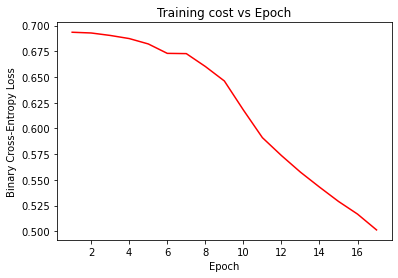

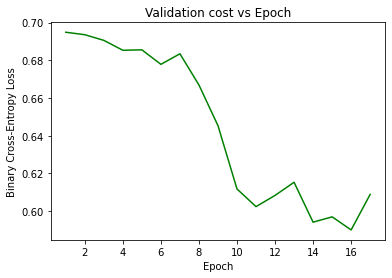

In [77]:
epoch_x = [x for x in range(1, len(train_loss)+1)]

plt.plot(epoch_x, train_loss, color = 'r')
plt.title("Training cost vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.show()

plt.plot(epoch_x, val_loss, color = 'g')
plt.title("Validation cost vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.show()

In [78]:
model.eval()
test_loss, test_acc, n_test = 0,0,0
test_iterator = tqdm(test_loader)
for xb, yb in test_iterator:
    xb = xb.to(device)
    yb = yb.to(device).to(float)
    y = model.forward(xb).to(float)
    
    loss = loss_fn(y, yb)

    test_loss += loss.item()

    cur_acc = 0
    for i in range(xb.shape[0]):
        if round(y[i].item()) == yb[i]:
            cur_acc += 1
    test_acc += cur_acc
    n_test += xb.shape[0]

    test_iterator.set_postfix(loss = loss.item(), accuracy = cur_acc/xb.shape[0])
print("Test Loss: ", test_loss)
print("Test_accuracy: ", test_acc/n_test)

100%|██████████| 250/250 [00:11<00:00, 20.95it/s, accuracy=0.72, loss=0.585]

Test Loss:  153.08234374479795
Test_accuracy:  0.68612


#### Question 2.6

IMDB movie review classification task using Glove-6B-300d embeddings.

Hyperparameters:

- Embedding dimension: 300
- Learning rate: 1e-3
- Stopping Criteria: Early Stopping
- Maximum epochs: 25

Test Accuracy: 88.048 %

The model trained using Glove embeddings performed better than the Tiny-Shakespeare based embeddings because, Glove is trained using a larger corpus with a larger vocabulary, whereas, Tiny-Shakespeare could provide embeddings for only 16.9% words in the IMDB corpus' vocabulary and the rest are initialized randomly (without any context).

In [79]:
from torchtext.vocab import GloVe

global_vectors = GloVe(name='6B', dim=300)

In [80]:
emb_dim = 300

embeds = torch.zeros(v2.__len__(), emb_dim)
for index in range(v2.__len__()):
    token = v2.lookup_token(index)
    embeds[index] = global_vectors.get_vecs_by_tokens(token, lower_case_backup=True)

In [86]:
model = SentimentClassifier(100, emb_dim, 600, v2.__len__(), embeds)
model.to(device)
model.train()

lr = 1e-3
opt = torch.optim.Adam(model.parameters(), lr=lr)

loss_fn = F.binary_cross_entropy

In [87]:
num_epochs = 25

sets = [train_loader, val_loader]
desc = ["Training", "Validation"]

train_loss, val_loss = [], []
for epoch in range(1, num_epochs+1):
    print("Epoch: ", epoch)

    for s in range(2):
        epoch_loss = 0
        acc = 0
        n = 0

        if s == 0:
            model.train()
        else:
            model.eval()

        iterator = tqdm(sets[s])
        for xb, yb in iterator:
            xb = xb.to(device)
            yb = yb.to(device).to(float)
            y = model.forward(xb).to(float)
            
            loss = loss_fn(y, yb)

            if s == 0:
                loss.backward()
                opt.step()
                opt.zero_grad()

            epoch_loss += loss.item()

            cur_acc = 0
            for i in range(xb.shape[0]):
                if round(y[i].item()) == yb[i]:
                    cur_acc += 1
            acc += cur_acc
            n += xb.shape[0]

            iterator.set_postfix(loss = loss.item(), accuracy = cur_acc/xb.shape[0], set=desc[s]+" set")
        print(desc[s]+" Loss: ", epoch_loss/len(sets[s]))
        print(desc[s]+" Accuracy: ", acc/n)
        if s == 0:
            train_loss.append(epoch_loss/len(sets[s]))
        else:
            val_loss.append(epoch_loss/len(sets[s]))

    if epoch > 10 and val_loss[-1] - val_loss[-2] > 0.1/len(sets[s]):
        print("--- Stopping Training ---")
        break

Epoch:  1


100%|██████████| 225/225 [00:27<00:00,  8.12it/s, accuracy=0.54, loss=0.693, set=Training set]


Training Loss:  0.6870031013246949
Training Accuracy:  0.5267111111111111


100%|██████████| 25/25 [00:01<00:00, 20.21it/s, accuracy=0.6, loss=0.692, set=Validation set] 


Validation Loss:  0.6928065177435127
Validation Accuracy:  0.5248
Epoch:  2


100%|██████████| 225/225 [00:28<00:00,  7.90it/s, accuracy=0.53, loss=0.692, set=Training set]


Training Loss:  0.691733106287059
Training Accuracy:  0.5361777777777778


100%|██████████| 25/25 [00:01<00:00, 19.90it/s, accuracy=0.53, loss=0.689, set=Validation set]


Validation Loss:  0.6898701262444555
Validation Accuracy:  0.6012
Epoch:  3


100%|██████████| 225/225 [00:28<00:00,  7.90it/s, accuracy=0.48, loss=0.694, set=Training set]


Training Loss:  0.6918921648863804
Training Accuracy:  0.5107555555555555


100%|██████████| 25/25 [00:01<00:00, 20.22it/s, accuracy=0.55, loss=0.692, set=Validation set]


Validation Loss:  0.6925047946908809
Validation Accuracy:  0.5248
Epoch:  4


100%|██████████| 225/225 [00:27<00:00,  8.08it/s, accuracy=0.48, loss=0.695, set=Training set]


Training Loss:  0.6932010311140325
Training Accuracy:  0.49724444444444443


100%|██████████| 25/25 [00:01<00:00, 19.65it/s, accuracy=0.51, loss=0.693, set=Validation set]


Validation Loss:  0.6914822048653311
Validation Accuracy:  0.5248
Epoch:  5


100%|██████████| 225/225 [00:28<00:00,  7.96it/s, accuracy=0.49, loss=0.694, set=Training set]


Training Loss:  0.6929248755809508
Training Accuracy:  0.5039555555555556


100%|██████████| 25/25 [00:01<00:00, 20.05it/s, accuracy=0.39, loss=0.694, set=Validation set]


Validation Loss:  0.6928635471488442
Validation Accuracy:  0.478
Epoch:  6


100%|██████████| 225/225 [00:28<00:00,  8.01it/s, accuracy=0.45, loss=0.694, set=Training set]


Training Loss:  0.692700943864331
Training Accuracy:  0.5040888888888889


100%|██████████| 25/25 [00:01<00:00, 20.47it/s, accuracy=0.47, loss=0.694, set=Validation set]


Validation Loss:  0.6931516229888145
Validation Accuracy:  0.4764
Epoch:  7


100%|██████████| 225/225 [00:28<00:00,  8.02it/s, accuracy=0.78, loss=0.467, set=Training set]


Training Loss:  0.6718890815580002
Training Accuracy:  0.5558666666666666


100%|██████████| 25/25 [00:01<00:00, 20.85it/s, accuracy=0.85, loss=0.437, set=Validation set]


Validation Loss:  0.48985706412558555
Validation Accuracy:  0.7884
Epoch:  8


100%|██████████| 225/225 [00:28<00:00,  7.97it/s, accuracy=0.8, loss=0.446, set=Training set] 


Training Loss:  0.3733538260125188
Training Accuracy:  0.8476888888888889


100%|██████████| 25/25 [00:01<00:00, 20.28it/s, accuracy=0.84, loss=0.392, set=Validation set]


Validation Loss:  0.32311995351185785
Validation Accuracy:  0.8668
Epoch:  9


100%|██████████| 225/225 [00:28<00:00,  7.90it/s, accuracy=0.87, loss=0.307, set=Training set]


Training Loss:  0.3117356509658106
Training Accuracy:  0.8772444444444445


100%|██████████| 25/25 [00:01<00:00, 20.13it/s, accuracy=0.91, loss=0.286, set=Validation set]


Validation Loss:  0.3327483865558212
Validation Accuracy:  0.866
Epoch:  10


100%|██████████| 225/225 [00:28<00:00,  7.94it/s, accuracy=0.87, loss=0.358, set=Training set]


Training Loss:  0.2773913936339055
Training Accuracy:  0.8907111111111111


100%|██████████| 25/25 [00:01<00:00, 19.69it/s, accuracy=0.91, loss=0.273, set=Validation set]


Validation Loss:  0.30880926762012495
Validation Accuracy:  0.8768
Epoch:  11


100%|██████████| 225/225 [00:28<00:00,  7.92it/s, accuracy=0.93, loss=0.213, set=Training set]


Training Loss:  0.24659560905629088
Training Accuracy:  0.9035111111111112


100%|██████████| 25/25 [00:01<00:00, 19.61it/s, accuracy=0.9, loss=0.25, set=Validation set]  


Validation Loss:  0.306725336171141
Validation Accuracy:  0.8768
Epoch:  12


100%|██████████| 225/225 [00:28<00:00,  7.94it/s, accuracy=0.95, loss=0.15, set=Training set] 


Training Loss:  0.22118405773481098
Training Accuracy:  0.9165333333333333


100%|██████████| 25/25 [00:01<00:00, 20.43it/s, accuracy=0.9, loss=0.211, set=Validation set] 

Validation Loss:  0.31963430922710595
Validation Accuracy:  0.8728
--- Stopping Training ---


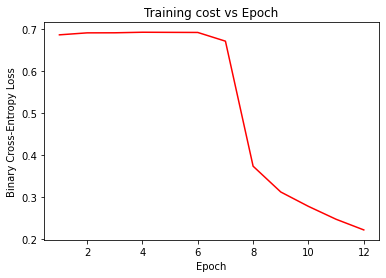

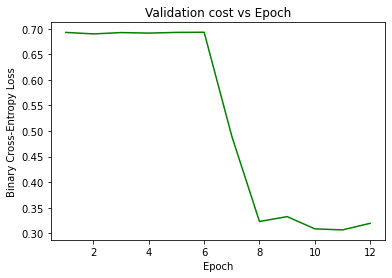

In [88]:
epoch_x = [x for x in range(1, len(train_loss)+1)]

plt.plot(epoch_x, train_loss, color = 'r')
plt.title("Training cost vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.show()

plt.plot(epoch_x, val_loss, color = 'g')
plt.title("Validation cost vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.show()

In [100]:
model.eval()
train_loss, test_acc, n_test = 0,0,0
train_iterator = tqdm(train_loader)

train_pred = []
train_true = []
for xb, yb in train_iterator:
    xb = xb.to(device)
    yb = yb.to(device).to(float)
    y = model.forward(xb).to(float)
    
    loss = loss_fn(y, yb)

    train_loss += loss.item()

    train_pred.extend(list(y.round().detach().cpu()))
    train_true.extend(list(yb.detach().cpu()))

from sklearn.metrics import classification_report

target_names = ["negative", "positive"]
print(classification_report(train_true, train_pred, target_names=target_names))

100%|██████████| 225/225 [00:09<00:00, 23.85it/s]


              precision    recall  f1-score   support

    negative       0.89      0.96      0.92     11312
    positive       0.95      0.88      0.92     11188

    accuracy                           0.92     22500
   macro avg       0.92      0.92      0.92     22500
weighted avg       0.92      0.92      0.92     22500



In [101]:
model.eval()
test_loss, test_acc, n_test = 0,0,0
test_iterator = tqdm(test_loader)

test_pred = []
test_true = []
for xb, yb in test_iterator:
    xb = xb.to(device)
    yb = yb.to(device).to(float)
    y = model.forward(xb).to(float)
    
    loss = loss_fn(y, yb)

    test_loss += loss.item()

    test_pred.extend(list(y.round().detach().cpu()))
    test_true.extend(list(yb.detach().cpu()))

    test_iterator.set_postfix(loss = loss.item())

target_names = ["negative", "positive"]
print(classification_report(test_true, test_pred, target_names=target_names))

100%|██████████| 250/250 [00:10<00:00, 24.07it/s, loss=0.135] 


              precision    recall  f1-score   support

    negative       0.85      0.92      0.89     12500
    positive       0.91      0.84      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

